# First `politician2vec` demo

## To do
- ~~Descriptive statistics/viz for entire dataset~~
- ~~Settle on centroid calculation method (handle outliers better, remove alt method?)~~
- ~~POC visualisations and projections of parliamentary dimensions~~
- Final visualisations and projections for all three venues
    - Abstract this into functions
- Compile populism-related words for constructing axes
- Consistently change "topic" to "party"/"cluster" or the like

In [ ]:
%pip uninstall politician2vec -y

In [ ]:
%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

In [4]:
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
import multiprocessing
available_workers = multiprocessing.cpu_count()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
test_data_path = 'data/clean/combined/subset_party_imputed_v2.p'

In [13]:
with open(test_data_path, 'rb') as p:
    test_data = pickle.load(p)

test_data.shape

(349594, 7)

In [51]:
# parl_data = test_data.loc[
#     (test_data['source'] == 'parliament') &
#     ~(test_data['party'].isin(['SIU', 'NQ', 'JF', 'SP']))
# ]
#
# tw_data = test_data.loc[
#     test_data['source'] == 'twitter'
# ]
#
meta_data = test_data.loc[
    (test_data['source'] == 'meta') &
    test_data['doc'].notna()
]

In [52]:
meta_data['party'].value_counts(dropna = False)

V      7182
SF     4900
S      3465
LA     3424
KF     2825
DF     2059
NB     1909
RV     1565
EL      823
FG      689
ALT     175
DD       76
M        28
KD       18
SIU       9
UFG       5
Name: party, dtype: int64

In [53]:
grouped_docs = meta_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()

In [54]:
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [55]:
ngram_options = {
    'min_count': 5,
    'threshold': 1,
    'delimiter': ' '
}

In [56]:
pol2vec_model = Politician2Vec(
    documents = docs,
    custom_clusters = parties,
    party_inference_method = 'mean',
    tokenizer = preproc_docs,
    embedding_model = 'doc2vec',
    min_count = 50,
    ngram_vocab = True,
    ngram_vocab_args = ngram_options,
    speed = 'deep-learn', # CHANGE FOR REAL RUNS
    workers = available_workers
    #doc2vec_vector_size = 300,
    #doc2vec_window = 8,
    #doc2vec_samples_threshold = 1e-5
)

2022-12-01 11:31:36,729 - politician2vec - INFO - Pre-processing documents for training
2022-12-01 11:31:58,368 - politician2vec - INFO - Creating joint document/word embedding


In [ ]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_topic(politician2vec_model, topic_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    topic.
    -------
    manual_num (int):  automatically assigned topic number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given topic.
        Default is to print all docs within a given topic.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of topic docs.
    '''

    num_topics = politician2vec_model.get_num_topics()
    topic_words, word_scores, topic_nums = politician2vec_model.get_topics(num_topics)

    # Get topic sizes so we know max n docs
    topic_sizes, topic_nums = politician2vec_model.get_topic_sizes()
    docs_to_return = topic_sizes[topic_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input topic id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_topic(
        topic_num=topic_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of topic docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', topic_words[topic_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [ ]:
word_vectors = pol2vec_model.model.wv
word_vectors.most_similar(positive = ['vermund'], topn = 25)

[('pernille', 0.6799238324165344),
 ('borgerlige', 0.3887028992176056),
 ('df', 0.35815221071243286),
 ('nb', 0.35693585872650146),
 ('afhængig', 0.33899885416030884),
 ('søndag', 0.2943767011165619),
 ('skipper', 0.28039953112602234),
 ('dfs', 0.2779603600502014),
 ('pia', 0.2754163146018982),
 ('politikerne', 0.26317086815834045),
 ('parti', 0.26140737533569336),
 ('r', 0.26127469539642334),
 ('regering', 0.2593846619129181),
 ('messerschmidt', 0.2564770579338074),
 ('islam', 0.25521987676620483),
 ('føre', 0.2513082027435303),
 ('dahl', 0.24949604272842407),
 ('mogensen', 0.2477979212999344),
 ('folkeparti', 0.24751470983028412),
 ('lars', 0.24540099501609802),
 ('vælgere', 0.2449638843536377),
 ('sjældent', 0.2448810487985611),
 ('tv', 0.24413539469242096),
 ('partileder', 0.24381791055202484),
 ('mand', 0.24360856413841248)]

In [361]:
inspect_topic(pol2vec_model, 0, n_docs=1, query_substr=None)

--- TOP 50 WORDS ---
 ['dkpol venstre' 'venstre kræver' 'danskerne ønsker' 'venstre ønsker'
 'venstre venstre' 'venstredk går' 'sikre danskerne' 'venstredk mette'
 'venstredk vores' 'nye formand' 'venstredk venstre' 'venstre ser'
 'før valg' 'både venstre' 'klar valg' 'gerne flere' 'ønsker venstre'
 'dkpol dkcivil' 'venstredk stor' 'danskerne flere' 'gør endnu'
 'venstredk ønsker' 'venstres forslag' 'venstre egentlig' 'venstre gik'
 'hvordan regeringen' 'foreslår venstre' 'giver danskerne'
 'mellem regeringen' 'danskerne klar' 'frederiksen ønsker'
 'venstredk hvorfor' 'venstre gerne' 'tilbage danskerne' 'siden venstre'
 'år tilbage' 'jakobellemann mangler' 'derfor venstre' 'danskerne får'
 'regeringen kommer' 'regering venstre' 'venstredk danmark' 'venstre gøre'
 'venstredk hjælpe' 'tror danskerne' 'endnu flere' 'gør brug'
 'danskere ønsker' 'formand klar' 'venstre klar'] 

--- TOP 1 DOCS. SUBSTRING QUERY: None (n = 1) ---
 ['RT @MortenDahlin: Et både ærligt og rammende interview af fo

In [ ]:
#model_path = 'embedding_models/politician2vec_test_meta_v1.txt'
model_path = 'embedding_models/politician2vec_meta_deeplearn_v1.txt'

In [ ]:
pol2vec_model.save(model_path)

_____

## Viz dev

In [5]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [6]:
n_words = len(doc2vec_model.wv)
n_docs = len(doc2vec_model.dv)
vocab = pol2vec_model.vocab

In [ ]:
# # TWITTER DEEPLEARN
# topic_labels = {
#    0: 'Venstre',
#    1: 'Socialdemokratiet',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale_Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'Alternativet',
#    9: 'Nye_Borgerlige',
#    10: 'Frie_Grønne',
#    11: 'Kristendemokraterne',
#    12: 'Moderaterne'
# }

In [ ]:
## PARLIAMENT FASTLEARN
#topic_labels = {
#    0: 'Socialdemokratiet',
#    1: 'Venstre',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'UFG',
#    9: 'Alternativet',
#    10: 'Danmarksdemokraterne',
#    11: 'Nye Borgerlige',
#    12: 'Frie Grønne',
#    13: 'Moderaterne',
#    14: 'Kristendemokraterne'
#}

In [7]:
# META FASTLEARN
topic_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'SF',
   4: 'Enhedslisten',
   5: 'Radikale_Venstre',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'Alternativet',
   9: 'Danmarksdemokraterne',
   10: 'Nye_Borgerlige',
   11: 'UFG',
   12: 'Frie_Grønne',
   13: 'Kristendemokraterne',
   14: 'Grønlandsk',
   15: 'Moderaterne'
}

In [8]:
topic_df = get_doc_topic_df(
    pol2vec_model,
    no_substantive_topics = 16,
    snippets = True
)

Topic sizes before filtering (topic 16 is "Other"):

[[ 0 35]
 [ 1 32]
 [ 2 15]
 [ 3 15]
 [ 4 13]
 [ 5 12]
 [ 6 11]
 [ 7  7]
 [ 8  6]
 [ 9  6]
 [10  5]
 [11  3]
 [12  3]
 [13  2]
 [14  1]]


In [9]:
import umap
import umap.plot
umap.plot.output_notebook(hide_banner=True)

In [10]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [18]:
topic_df['party'] = parties
topic_df['color'] = topic_df['party'].map(colormap)
cmap = topic_df[['snippet', 'color']].set_index('snippet').to_dict()
topic_df['full_name'] = grouped_docs['full_name']

In [19]:
topic_labels = topic_df.drop_duplicates(keep = 'last', subset = 'top')[['top', 'party']].sort_values(by = 'top').set_index('top').reset_index(drop=True)

In [20]:
topic_labels

,party
0,V
1,S
2,DF
3,EL
4,RV
5,KF
6,SF
7,UFG
8,LA
9,ALT


In [21]:
partyvecs = pol2vec_model.topic_vectors
partylabels = pd.DataFrame(topic_labels['party'])

In [22]:
combined_hover = pd.concat([topic_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

In [25]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=2
    ).fit(
        np.vstack([
            pol2vec_model.document_vectors,
            pol2vec_model.topic_vectors
            ]))

### Interactive UMAP plot (2D only)

In [46]:
from bokeh.models import Label, LabelSet, ColumnDataSource

In [47]:
plab_source = ColumnDataSource(dict(
    x = list(mapper.embedding_.T[0][166:]),
    y=list(mapper.embedding_.T[1][166:]),
    text=list(combined_hover.loc[combined_hover['full_name'].isna(), 'party'].values)
    ))

In [50]:
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

### PCA: Project parties to first principal component

In [524]:
pca = PCA(n_components=3)

In [531]:
reduced = pca.fit_transform(
    np.vstack([
        #pol2vec_model.document_vectors,
        pol2vec_model.topic_vectors
        ]))

In [520]:
only_party_labs = combined_hover
only_party_labs.loc[only_party_labs['full_name'].notna(),'party'] = ''
only_party_labs = only_party_labs[166:].reset_index(drop=True)

In [521]:
only_party_labs['color'] = only_party_labs['party'].map(colormap)

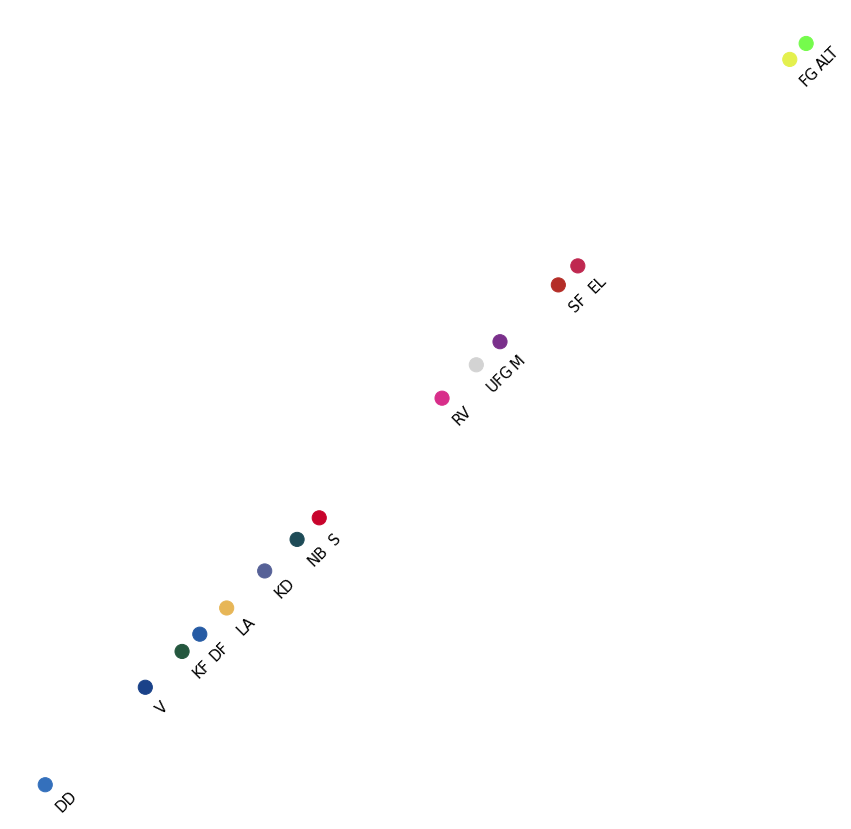

In [545]:
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

for i in range(len(reduced)):
    plt.annotate(only_party_labs['party'][i], (reduced.T[component][i]+0.01, reduced.T[component][i]-0.035), size = 15, rotation = 45)

### Static 3D UMAP plot

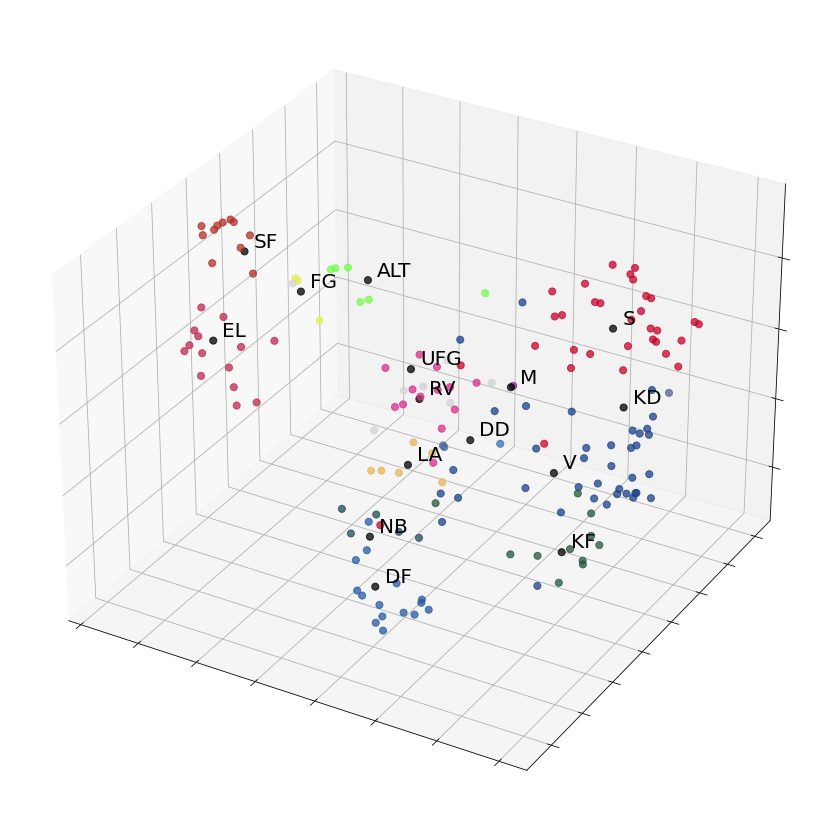

In [523]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

____

## TensorBoard exports

In [ ]:
doc2vec2tensor(
    doc2vec_model,
    temp_w2v_path = 'tensorboard_input/temp/doc_tensor_meta.w2v',
    tsv_prefix = 'tensorboard_input/meta',
    output_docvecs = True,
    output_wordvecs = False
)

In [ ]:
metadata2tensor(
    topic_df,
    metadata_path = 'tensorboard_input/meta_metadata.tsv',
    label_list = topic_labels
)

In [ ]:
# test read of tensor output
with open('tensorboard_input/meta_tensor.tsv','r') as r:
    lines_test = r.readlines()

len(lines_test)

In [ ]:
def partyvecs2tensor(party_vecs, out_path):
    vec_strs = []

    for vec in party_vecs:
        vec_str = ''.join([str(val) +'\t' for val in vec]).rstrip('\t')
        vec_strs.append(vec_str)

    tensor_str = '\n'.join(vec_strs)
    
    with open(out_path, 'w') as f:
        f.write(tensor_str)

In [ ]:
def concat_tensors(tensor_files, out_path):
    tensor_strs = []
    
    for file in tensor_files:
        tensor_str = pd.read_csv(file, sep = '\t', header = None)
        tensor_strs.append(tensor_str)
    
    concat_tensor = pd.concat(tensor_strs)
    
    concat_tensor.to_csv(out_path, sep = '\t', header = False, index = False)

In [ ]:
partyvecs2tensor(
    party_vecs = pol2vec_model.topic_vectors,
    out_path = 'tensorboard_input/meta_parties.tsv'
)

In [ ]:
label_df = pd.DataFrame(topic_labels, index = ['doc']).T
#label_df['topic'] = ''

In [ ]:
label_df.to_csv(
    'tensorboard_input/meta_parties_metadata.tsv',
    sep = '\t',
    header = False,
    index = False
)

In [ ]:
# Combine docvecs and partyvecs
politician_file = 'tensorboard_input/meta_tensor.tsv'
party_file = 'tensorboard_input/meta_parties.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined.tsv')

In [ ]:
# Combine metadata
politician_file = 'tensorboard_input/meta_metadata.tsv'
party_file = 'tensorboard_input/meta_parties_metadata.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined_metadata.tsv')